In [41]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact, fixed
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM, Lambda, Dropout, Conv1D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Examining and plotting the data

In [2]:
data = pd.read_csv(data_path, parse_dates=['Datetime'], index_col='Datetime')

In [3]:
data.sort_index(inplace=True)
data.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [4]:
print('Shape of the data: {}'.format(data.shape))
print('Missing rows: {}'.format(int(data.isnull().sum(axis=0))))
print('Data starts at: {}'.format(data.index.min()))
print('Data ends at: {}'.format(data.index.max()))

Shape of the data: (145366, 1)
Missing rows: 0
Data starts at: 2002-01-01 01:00:00
Data ends at: 2018-08-03 00:00:00


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.0,62009.0


Text(0, 0.5, 'Number of hours with a given consumption')

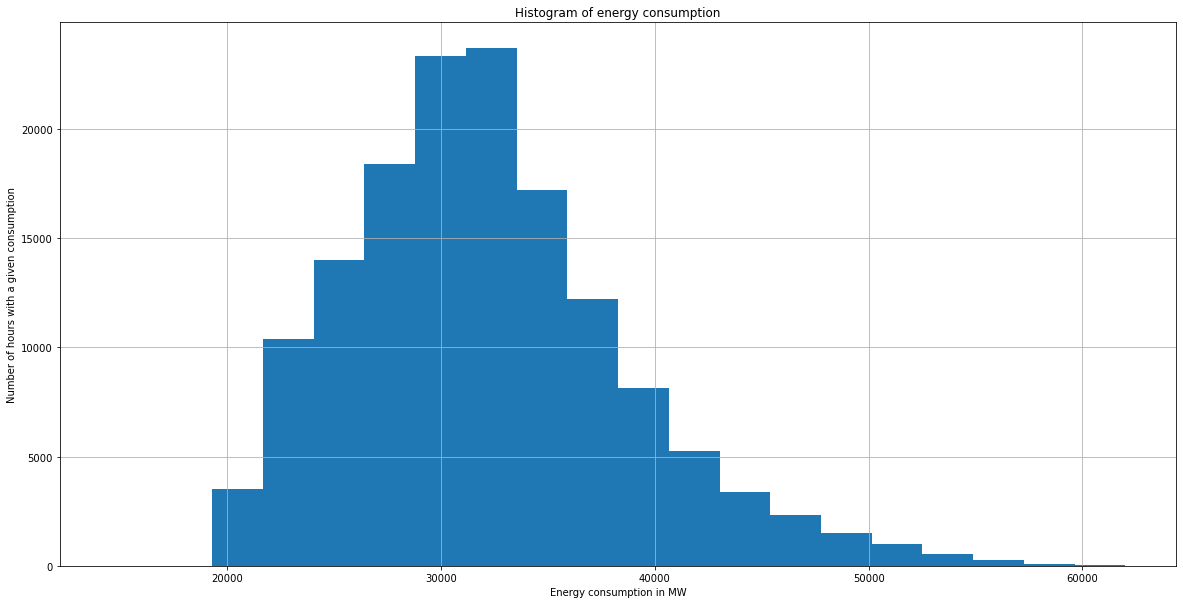

In [6]:
data.hist(bins=20, figsize=(20,10))
plt.title('Histogram of energy consumption')
plt.xlabel('Energy consumption in MW')
plt.ylabel('Number of hours with a given consumption')

Text(0, 0.5, 'Energy [MW]')

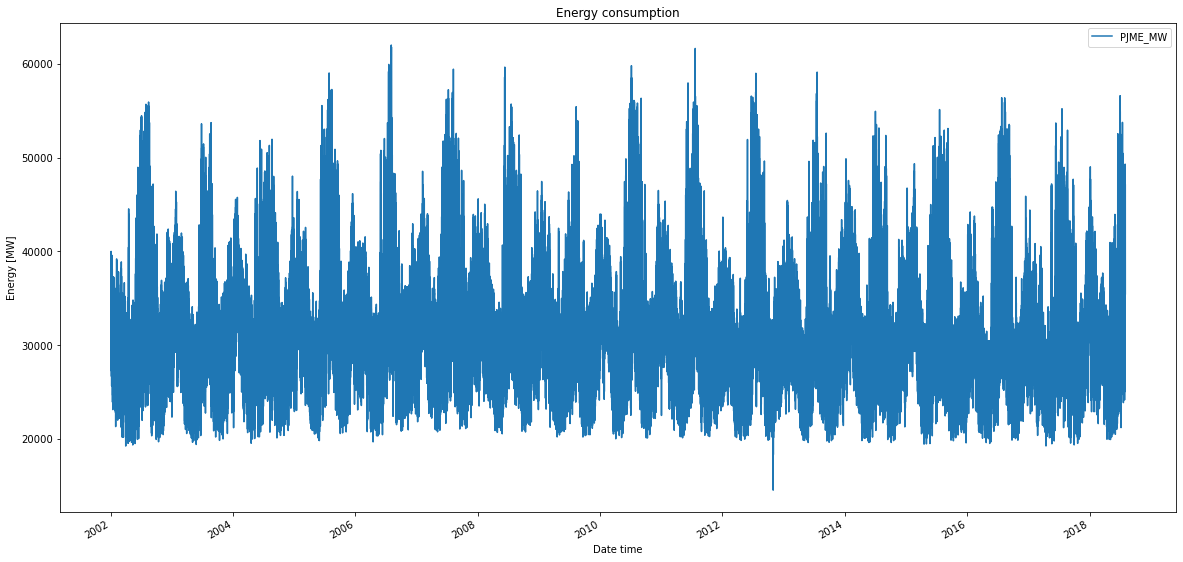

In [7]:
data.plot(figsize=(20,10))
plt.title('Energy consumption')
plt.xlabel('Date time')
plt.ylabel('Energy [MW]')

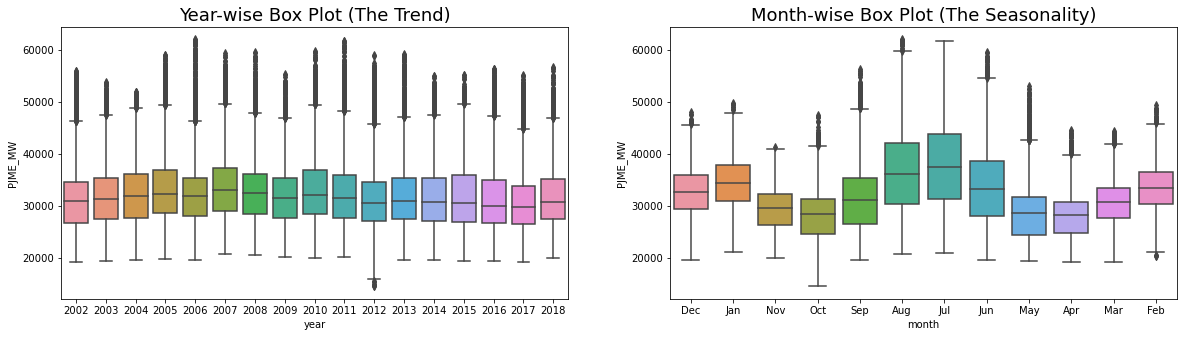

In [10]:
df = pd.read_csv(data_path, parse_dates=['Datetime'])

df['year'] = [d.year for d in df.Datetime]
df['month'] = [d.strftime('%b') for d in df.Datetime]
years = df['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x='year', y='PJME_MW', data=df, ax=axes[0])
sns.boxplot(x='month', y='PJME_MW', data=df)

axes[0].set_title('Year-wise Box Plot (The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot (The Seasonality)', fontsize=18)
plt.show()

In [11]:
def plotting_sesonality(data, year, month, day):
    data['{}-01-01 00:00:00'.format(year) : '{}-12-30 23:00:00'.format(year)].plot(figsize=(15, 8))
    plt.title('Seasonality during the year')
    plt.xlabel('Date time')
    plt.ylabel('Energy consumption [MW]')
    data['{}-{}-{} 00:00:00'.format(year, month, day) : '{}-{}-{} 23:00:00'.format(year, month, day+ 7)].plot(figsize=(15, 8))
    plt.title('Seasonality during the week')
    plt.xlabel('Date time')
    plt.ylabel('Energy consumption [MW]')
    data['{}-{}-{} 00:00:00'.format(year, month, day) : '{}-{}-{} 23:00:00'.format(year, month, day)].plot(figsize=(15,8))
    plt.title('Seasonality during the day')
    plt.plot()
    plt.xlabel('Date time')
    plt.ylabel('Energy consumption [MW]')

In [12]:
years = [] 
for i in range(2002, 2019, 1):
    years.append((str(i), i))

months = [('Jan.', 1), ('Feb.', 2), ('Mar.', 3), ('Apr.', 4), ('May', 5), ('June', 6), ('July', 7),
         ('Aug.', 8), ('Sept.', 9), ('Oct.', 10), ('Nov.', 11), ('Dec.', 12)]

interact(plotting_sesonality,data=fixed(data), year=years, month=months, day=(1,30,1))

interactive(children=(Dropdown(description='year', options=(('2002', 2002), ('2003', 2003), ('2004', 2004), ('…

<function __main__.plotting_sesonality(data, year, month, day)>

#### Decomposition of the data

<ipython-input-13-22c8ed99d128>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  multiplicative_decomposition = seasonal_decompose(data['PJME_MW'], model='multiplicative',freq=frequency, extrapolate_trend='freq')
<ipython-input-13-22c8ed99d128>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  additive_decomposition = seasonal_decompose(data['PJME_MW'], model='additive',freq=frequency, extrapolate_trend='freq')


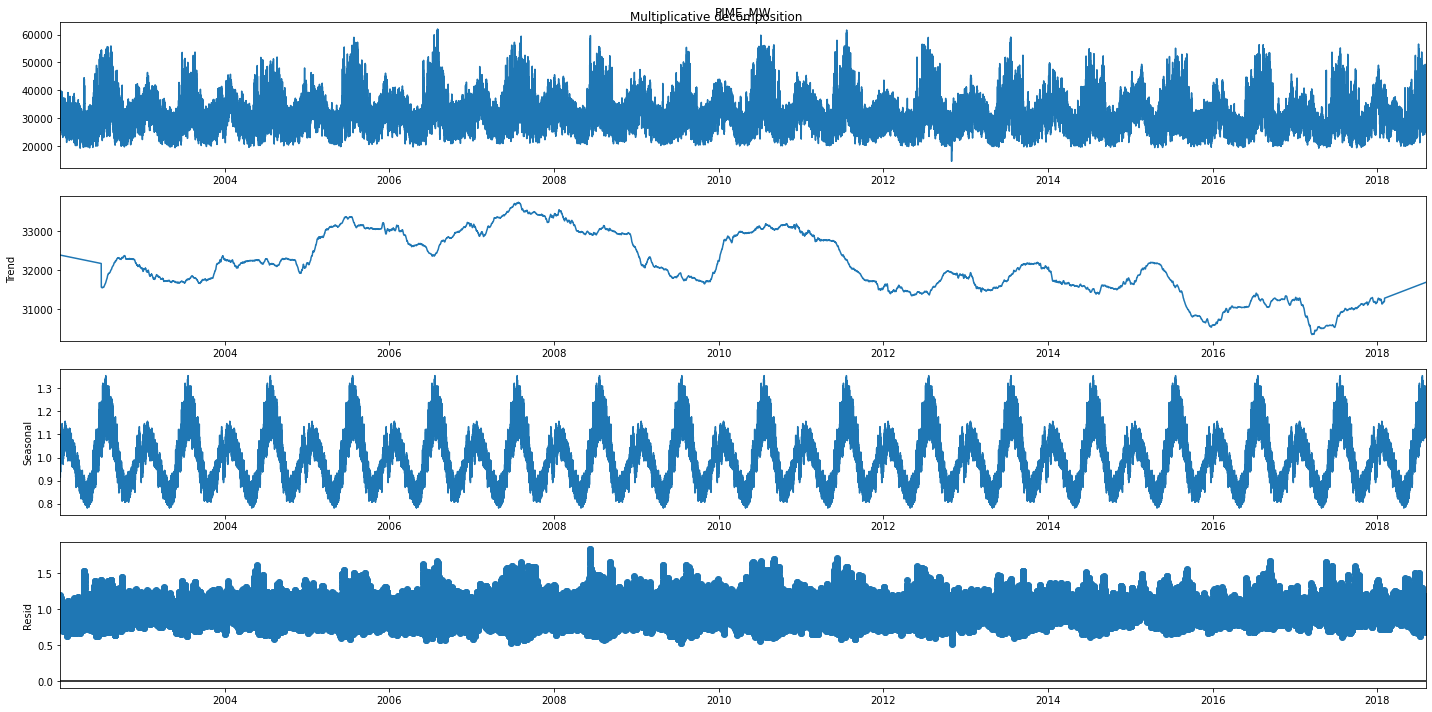

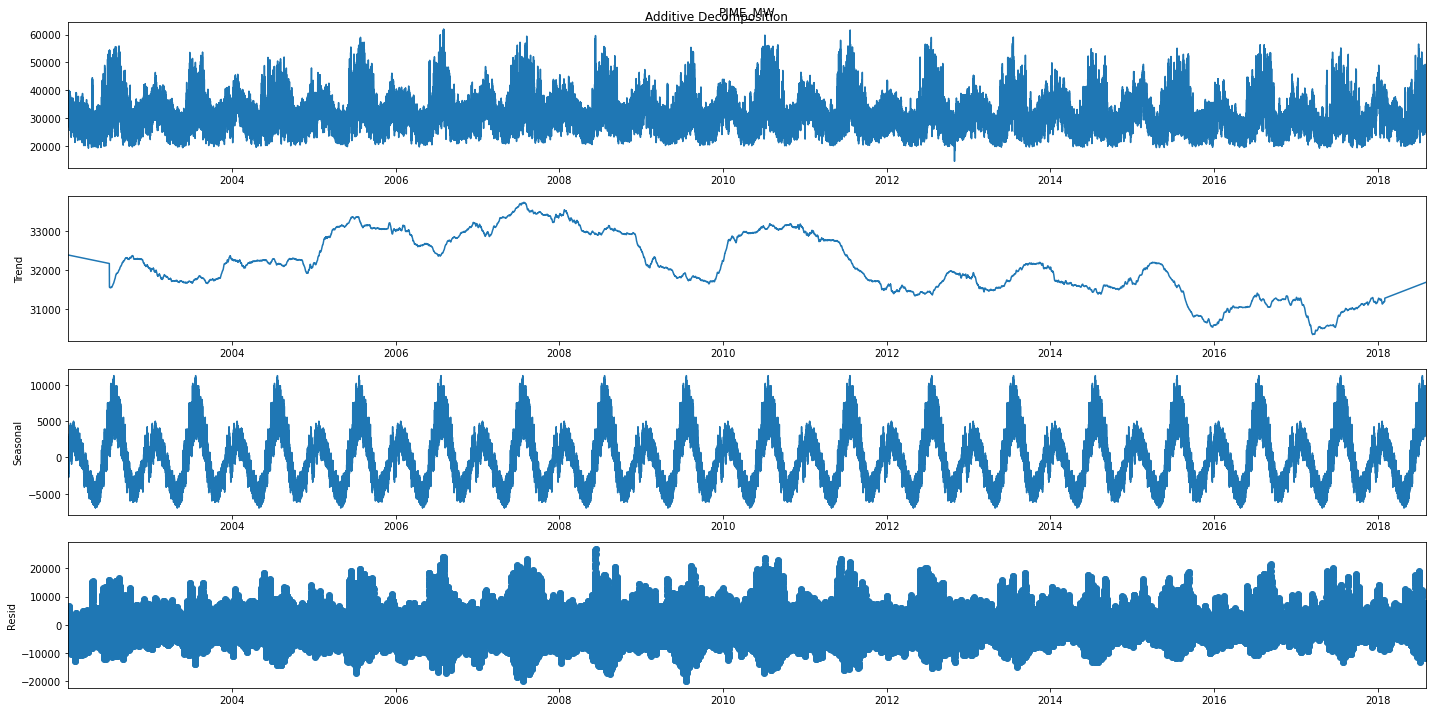

In [13]:
frequency = 24 * 365

def decomposition(frequency):
    multiplicative_decomposition = seasonal_decompose(data['PJME_MW'], model='multiplicative',freq=frequency, extrapolate_trend='freq')
    additive_decomposition = seasonal_decompose(data['PJME_MW'], model='additive',freq=frequency, extrapolate_trend='freq')

    matplotlib.rcParams['figure.figsize'] = [20, 10]
    multiplicative_decomposition.plot().suptitle('Multiplicative decomposition')
    additive_decomposition.plot().suptitle('Additive Decomposition')
    plt.show()
    

decomposition(frequency)

#### Moving average

In [14]:
def moving_average(data, window_size):
    window_size_days = window_size * 24
    data.plot(figsize=(20,10))
    data['moving_average'] = data.iloc[:,0].rolling(window=window_size_days).mean()
    data.moving_average.plot(figsize=(20,10))
    plt.plot()
    plt.title('Moving average')
    plt.xlabel('Date time')
    plt.ylabel('Energy consumption [MW]')
    plt.legend(['Original', 'Averaged'])
    data.drop('moving_average', axis=1, inplace=True)
    
interact(moving_average, data=fixed(data), window_size=widgets.IntSlider(min=10, max=90, step=3, value=7));

interactive(children=(IntSlider(value=10, description='window_size', max=90, min=10, step=3), Output()), _dom_…

## Preparing data

#### Stationarity of time series

In [15]:
df_stat = df.drop(['year', 'month'], axis=1).set_index('Datetime')

def checking_stationarity(data):
    stat = adfuller(data.PJME_MW.values, autolag='AIC')
    print('ADF statistic: {}'.format(stat[0]))
    print('P-value: {}'.format(stat[1]))

    for key, value in stat[4].items():
        print('Critical Values: {}, {}'.format(key, value))
        
checking_stationarity(df_stat)

ADF statistic: -18.828912729084205
P-value: 2.0221245081527322e-30
Critical Values: 1%, -3.430395009088914
Critical Values: 5%, -2.861559893380481
Critical Values: 10%, -2.5667805885384065


In [16]:
checking_stationarity(df_stat.diff().dropna())

ADF statistic: -55.475196799282514
P-value: 0.0
Critical Values: 1%, -3.430395009088914
Critical Values: 5%, -2.861559893380481
Critical Values: 10%, -2.5667805885384065


So, the original data is stationary to the sufficient level.

In [17]:
window_size = 30
window_shift = 1
train_len = int(len(data) * 0.8)
val_len = int(len(data) * 0.9)

In [18]:
def scale_split(df, train_len, val_len):
    train_dataset = df.iloc[:train_len]
    val_dataset = df.iloc[train_len:val_len]
    test_dataset = df.iloc[val_len:]
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(train_dataset)
    train = scaler.transform(train_dataset)
    val = scaler.transform(val_dataset)
    test = scaler.transform(test_dataset)
    
    return train, val, test

def load_data(data, seq_len):
    X = []
    y = []
    
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len : i, 0])
        y.append(data[i, 0])
        
    X = np.reshape(X, (-1, seq_len, 1))
    y = np.array(y)
    
    return X, y

In [19]:
train, val, test = scale_split(data, train_len, val_len)

X_train, y_train = load_data(train, seq_len=20)
X_val, y_val = load_data(val, seq_len=20)
X_test, y_test = load_data(test, seq_len=20)

### Modeling

#### Single layer network

In [20]:
model_single_layer = Sequential([
    Lambda(lambda x: tf.squeeze(x, axis=-1), input_shape=[20, None]),
    Dense(1)
])
model_single_layer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [27]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model_single_layer.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
single_layer_lr_history = model_single_layer.fit(X_train, y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.5595 - mae: 1.0506
Epoch 2/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.5594 - mae: 1.0505A: 0s - loss: 0.5599 - m
Epoch 3/100
3634/3634 [==============================] - 4s 986us/step - loss: 0.5593 - mae: 1.0504
Epoch 4/100
3634/3634 [==============================] - 5s 1ms/step - loss: 0.5591 - mae: 1.0501
Epoch 5/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.5588 - mae: 1.0499
Epoch 6/100
3634/3634 [==============================] - 4s 992us/step - loss: 0.5582 - mae: 1.0493
Epoch 7/100
3634/3634 [==============================] - 3s 908us/step - loss: 0.5574 - mae: 1.0484
Epoch 8/100
3634/3634 [==============================] - 3s 904us/step - loss: 0.5564 - mae: 1.0473
Epoch 9/100
3634/3634 [==============================] - 3s 922us/step - loss: 0.5548 - mae: 1.0456
Epoch 10/100
3634/3634 [==============================] - 3s 911us/step - loss: 0.55

3634/3634 [==============================] - 4s 1ms/step - loss: 0.0536 - mae: 0.1834
Epoch 82/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.2272 - mae: 0.3694
Epoch 83/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.2447 - mae: 0.4402
Epoch 84/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.3787 - mae: 0.6337
Epoch 85/100
3634/3634 [==============================] - 4s 1ms/step - loss: 0.7304 - mae: 1.0421
Epoch 86/100
3634/3634 [==============================] - 4s 1ms/step - loss: 1.0618 - mae: 1.4628
Epoch 87/100
3634/3634 [==============================] - 4s 1ms/step - loss: 1.8479 - mae: 2.2913
Epoch 88/100
3634/3634 [==============================] - 4s 997us/step - loss: 2.8219 - mae: 3.2865
Epoch 89/100
3634/3634 [==============================] - 4s 1ms/step - loss: 3.6259 - mae: 4.1030
Epoch 90/100
3634/3634 [==============================] - 6s 2ms/step - loss: 5.0741 - mae: 5.5556
Epoch 91/100
3634/363

(1e-05, 1.0, 0.0, 0.001)

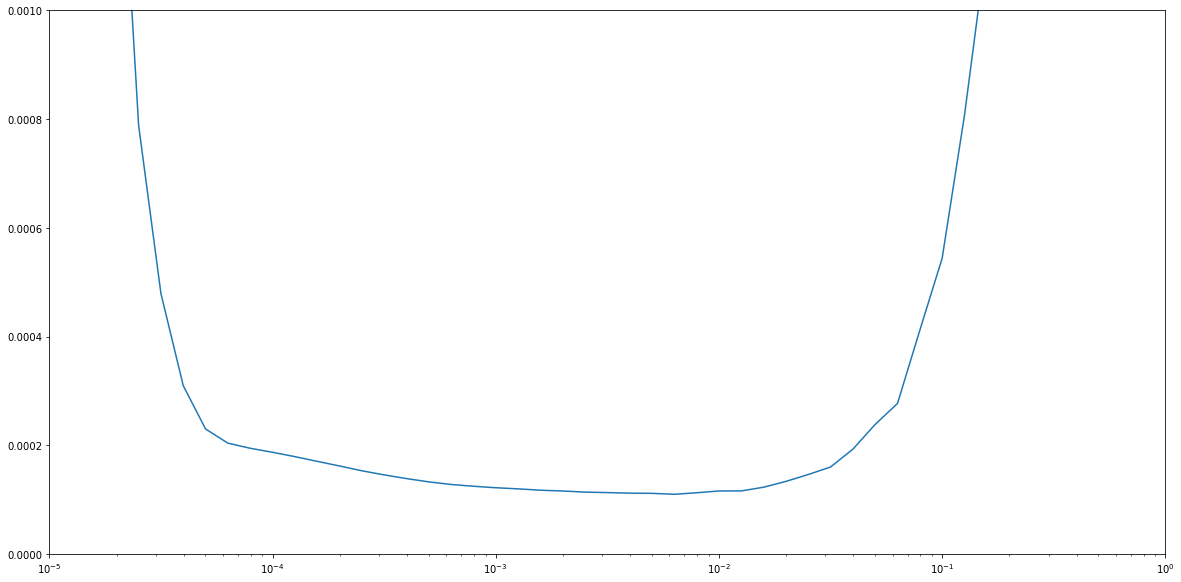

In [29]:
plt.semilogx(single_layer_lr_history.history['lr'], single_layer_lr_history.history['loss'])
plt.axis([1e-5, 1, 0, 10e-4])

According to plot above, the most optimal rate for learning rate is around 2e-3

In [30]:
optimizer = tf.keras.optimizers.Adam(lr=2e-3)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model_single_layer.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model_single_layer_history = model_single_layer.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), 
                                                    callbacks=[early_stop])

Epoch 1/50
3634/3634 [==============================] - 4s 1ms/step - loss: 13.6999 - mae: 14.1907 - val_loss: 4.5696 - val_mae: 5.0515
Epoch 2/50
3634/3634 [==============================] - 4s 1ms/step - loss: 2.9525 - mae: 3.4213 - val_loss: 1.8610 - val_mae: 2.3177
Epoch 3/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.9829 - mae: 1.4065 - val_loss: 0.5086 - val_mae: 0.9016
Epoch 4/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.3472 - mae: 0.6980 - val_loss: 0.1946 - val_mae: 0.5023
Epoch 5/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.2404 - mae: 0.5661 - val_loss: 0.1661 - val_mae: 0.4634
Epoch 6/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.2153 - mae: 0.5340 - val_loss: 0.1504 - val_mae: 0.4393
Epoch 7/50
3634/3634 [==============================] - 5s 1ms/step - loss: 0.1959 - mae: 0.5072 - val_loss: 0.1359 - val_mae: 0.4165
Epoch 8/50
3634/3634 [==============================] - 5s 1

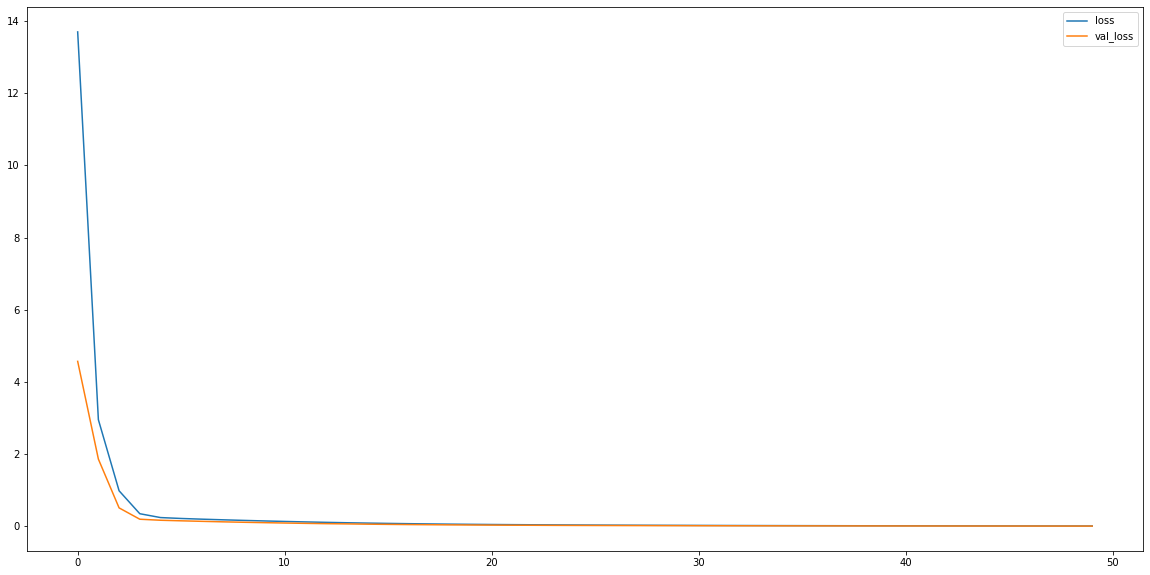

[]

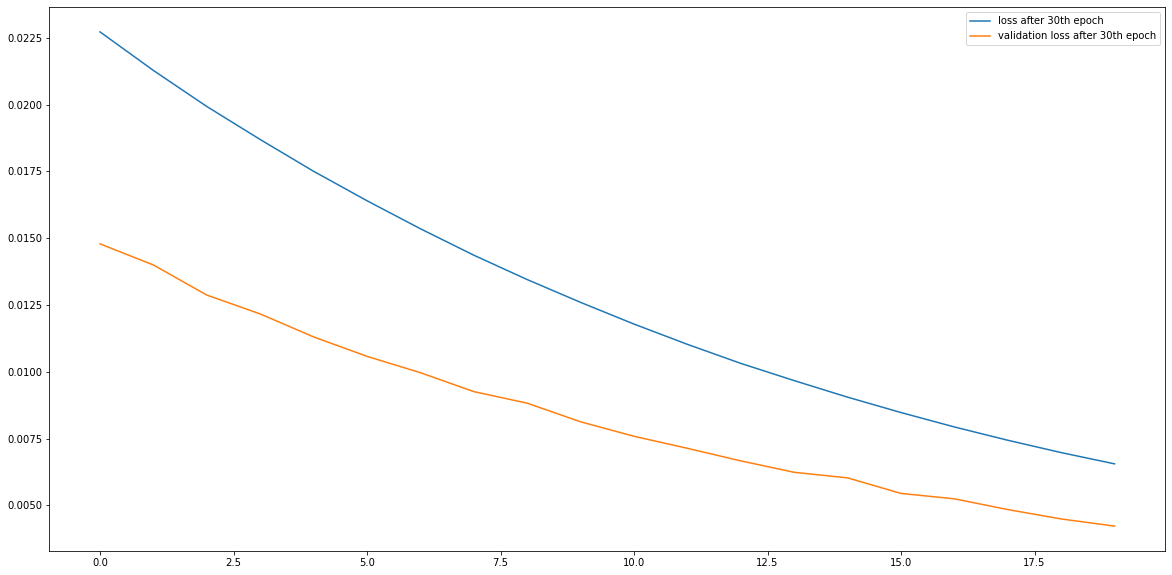

In [32]:
loss_single_layer = model_single_layer_history.history['loss']
mae_single_layer = model_single_layer_history.history['mae']
val_loss_single_layer = model_single_layer_history.history['val_loss']
val_mae_single_layer = model_single_layer_history.history['val_mae']


plt.plot(loss_single_layer, label='loss')
plt.plot(val_loss_single_layer, label='val_loss')
plt.legend()
plt.show()

plt.plot(loss_single_layer[30:], label='loss after 30th epoch')
plt.plot(val_loss_single_layer[30:], label='validation loss after 30th epoch')
plt.legend()
plt.plot()

In [33]:
model_single_layer_history = model_single_layer.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), 
                                                    callbacks=[early_stop])

Epoch 1/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.0062 - mae: 0.0878 - val_loss: 0.0039 - val_mae: 0.0709
Epoch 2/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.0058 - mae: 0.0849 - val_loss: 0.0038 - val_mae: 0.0695
Epoch 3/50
3634/3634 [==============================] - 5s 1ms/step - loss: 0.0054 - mae: 0.0822 - val_loss: 0.0035 - val_mae: 0.0665
Epoch 4/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.0051 - mae: 0.0797 - val_loss: 0.0033 - val_mae: 0.0654
Epoch 5/50
3634/3634 [==============================] - 5s 2ms/step - loss: 0.0048 - mae: 0.0772 - val_loss: 0.0031 - val_mae: 0.0629
Epoch 6/50
3634/3634 [==============================] - 5s 1ms/step - loss: 0.0046 - mae: 0.0750 - val_loss: 0.0029 - val_mae: 0.0608
Epoch 7/50
3634/3634 [==============================] - 4s 1ms/step - loss: 0.0044 - mae: 0.0729 - val_loss: 0.0028 - val_mae: 0.0593
Epoch 8/50
3634/3634 [==============================] - 4s 1ms

In [34]:
model_single_layer_history = model_single_layer.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), 
                                                    callbacks=[early_stop])

Epoch 1/20
3634/3634 [==============================] - 4s 1ms/step - loss: 9.6860e-04 - mae: 0.0342 - val_loss: 6.4117e-04 - val_mae: 0.0282
Epoch 2/20
3634/3634 [==============================] - 4s 1ms/step - loss: 9.4237e-04 - mae: 0.0338 - val_loss: 6.8946e-04 - val_mae: 0.0294
Epoch 3/20
3634/3634 [==============================] - 4s 1ms/step - loss: 9.1235e-04 - mae: 0.0333 - val_loss: 5.7095e-04 - val_mae: 0.0267
Epoch 4/20
3634/3634 [==============================] - 4s 1ms/step - loss: 8.8922e-04 - mae: 0.0329 - val_loss: 5.5541e-04 - val_mae: 0.0263
Epoch 5/20
3634/3634 [==============================] - 4s 1ms/step - loss: 8.6251e-04 - mae: 0.0324 - val_loss: 5.9237e-04 - val_mae: 0.0272
Epoch 6/20
3634/3634 [==============================] - 5s 1ms/step - loss: 8.3874e-04 - mae: 0.0320 - val_loss: 5.3493e-04 - val_mae: 0.0259
Epoch 7/20
3634/3634 [==============================] - 4s 1ms/step - loss: 8.1175e-04 - mae: 0.0315 - val_loss: 5.1109e-04 - val_mae: 0.0253
Epoch 

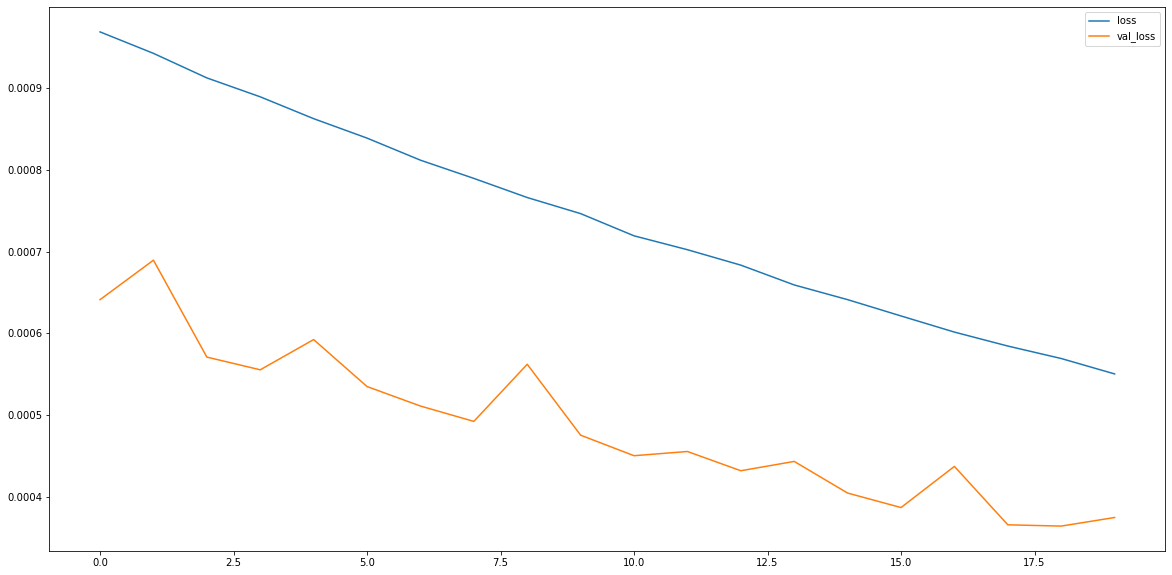

In [37]:
loss_single_layer = model_single_layer_history.history['loss']
mae_single_layer = model_single_layer_history.history['mae']
val_loss_single_layer = model_single_layer_history.history['val_loss']
val_mae_single_layer = model_single_layer_history.history['val_mae']


plt.plot(loss_single_layer, label='loss')
plt.plot(val_loss_single_layer, label='val_loss')
plt.legend()
plt.show()

In [38]:
model_single_layer_history = model_single_layer.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), 
                                                    callbacks=[early_stop])

Epoch 1/20
3634/3634 [==============================] - 4s 1ms/step - loss: 5.3371e-04 - mae: 0.0258 - val_loss: 3.3593e-04 - val_mae: 0.0208
Epoch 2/20
3634/3634 [==============================] - 5s 1ms/step - loss: 5.1848e-04 - mae: 0.0254 - val_loss: 3.3540e-04 - val_mae: 0.0208
Epoch 3/20
3634/3634 [==============================] - 5s 1ms/step - loss: 5.0122e-04 - mae: 0.0250 - val_loss: 3.1645e-04 - val_mae: 0.0201
Epoch 4/20
3634/3634 [==============================] - 5s 1ms/step - loss: 4.8761e-04 - mae: 0.0247 - val_loss: 3.1701e-04 - val_mae: 0.0201
Epoch 5/20
3634/3634 [==============================] - 4s 1ms/step - loss: 4.7309e-04 - mae: 0.0243 - val_loss: 3.1828e-04 - val_mae: 0.0203
Epoch 6/20
3634/3634 [==============================] - 4s 1ms/step - loss: 4.5775e-04 - mae: 0.0240 - val_loss: 2.8660e-04 - val_mae: 0.0192
Epoch 7/20
3634/3634 [==============================] - 5s 1ms/step - loss: 4.4410e-04 - mae: 0.0236 - val_loss: 3.0892e-04 - val_mae: 0.0200
Epoch 

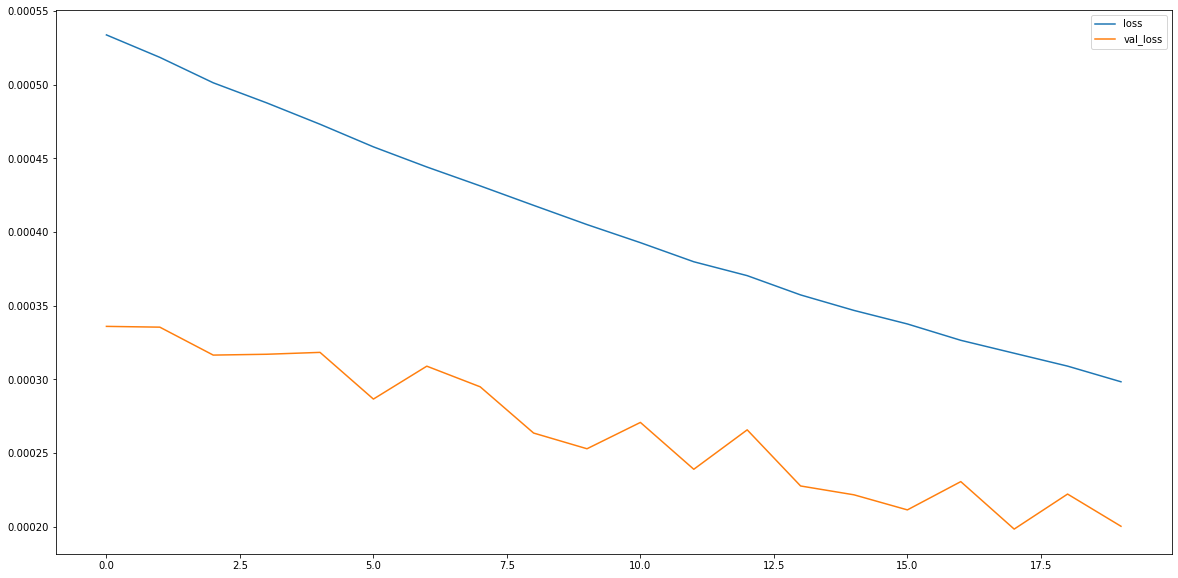

[]

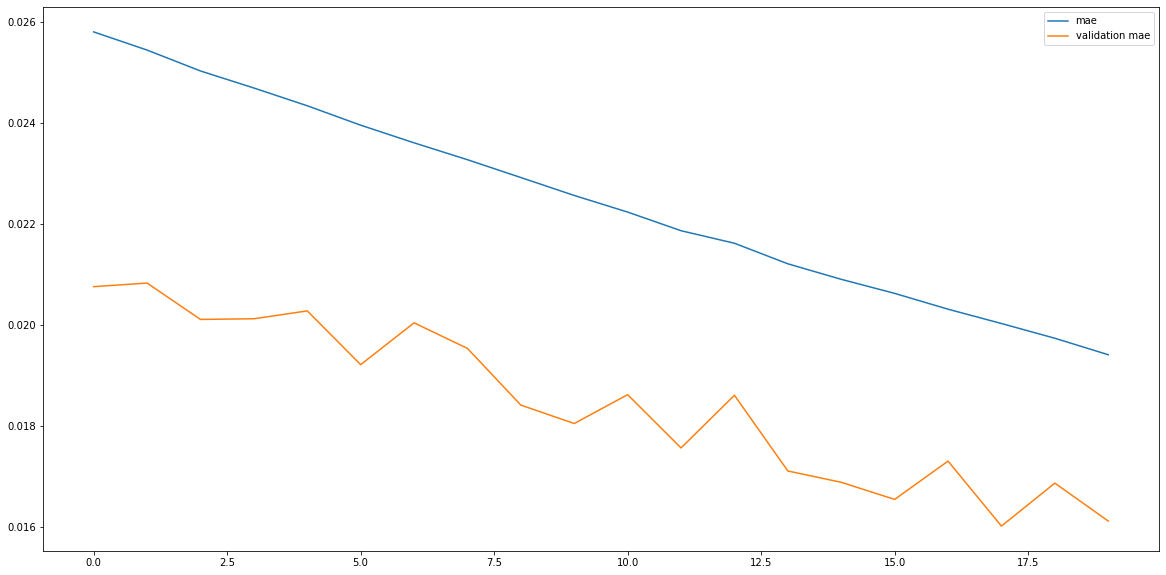

In [39]:
loss_single_layer = model_single_layer_history.history['loss']
mae_single_layer = model_single_layer_history.history['mae']
val_loss_single_layer = model_single_layer_history.history['val_loss']
val_mae_single_layer = model_single_layer_history.history['val_mae']


plt.plot(loss_single_layer, label='loss')
plt.plot(val_loss_single_layer, label='val_loss')
plt.legend()
plt.show()

plt.plot(mae_single_layer, label='mae')
plt.plot(val_mae_single_layer, label='validation mae')
plt.legend()
plt.plot()

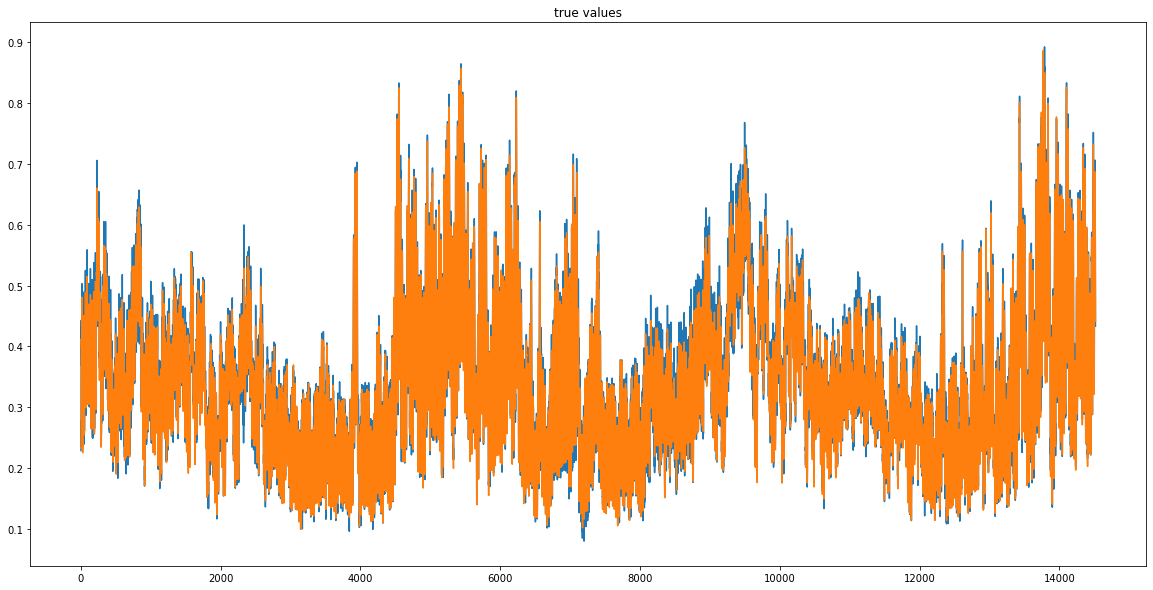

In [44]:
predictions = model_single_layer.predict(X_test)
matplotlib.rcParams['figure.figsize'] = [20, 10]
plt.plot(predictions)
plt.title('predictions')
plt.plot(y_test)
plt.title('true values')
plt.show()

In [45]:
mse_single_layer = mean_squared_error(y_test, predictions)
print('Mean squared error = ', mse_single_layer)

Mean squared error =  0.00037687952740214197


#### Multiple layers network

In [46]:
model_multiple_layers = Sequential([
    Lambda(lambda x: tf.squeeze(x, axis=-1), input_shape=[20, None]),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_multiple_layers.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model_multiple_layers.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
model_multiple_layers_history = model_multiple_layers.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                                                         callbacks=[early_stop])

Epoch 1/50
3634/3634 [==============================] - 9s 2ms/step - loss: 0.0010 - mae: 0.0312 - val_loss: 2.5074e-04 - val_mae: 0.0182
Epoch 2/50
3634/3634 [==============================] - 9s 2ms/step - loss: 3.7371e-04 - mae: 0.0205 - val_loss: 4.8036e-04 - val_mae: 0.0271
Epoch 3/50
3634/3634 [==============================] - 9s 2ms/step - loss: 3.3244e-04 - mae: 0.0193 - val_loss: 4.6637e-04 - val_mae: 0.0256
Epoch 4/50
3634/3634 [==============================] - 10s 3ms/step - loss: 3.0740e-04 - mae: 0.0185 - val_loss: 3.0096e-04 - val_mae: 0.0191
Epoch 5/50
3634/3634 [==============================] - 9s 3ms/step - loss: 2.9104e-04 - mae: 0.0181 - val_loss: 4.3734e-04 - val_mae: 0.0236
Epoch 6/50
3634/3634 [==============================] - 9s 3ms/step - loss: 2.7981e-04 - mae: 0.0177 - val_loss: 4.3918e-04 - val_mae: 0.0252
Epoch 7/50
3634/3634 [==============================] - 10s 3ms/step - loss: 2.6936e-04 - mae: 0.0173 - val_loss: 6.4110e-04 - val_mae: 0.0304
Epoch 8/

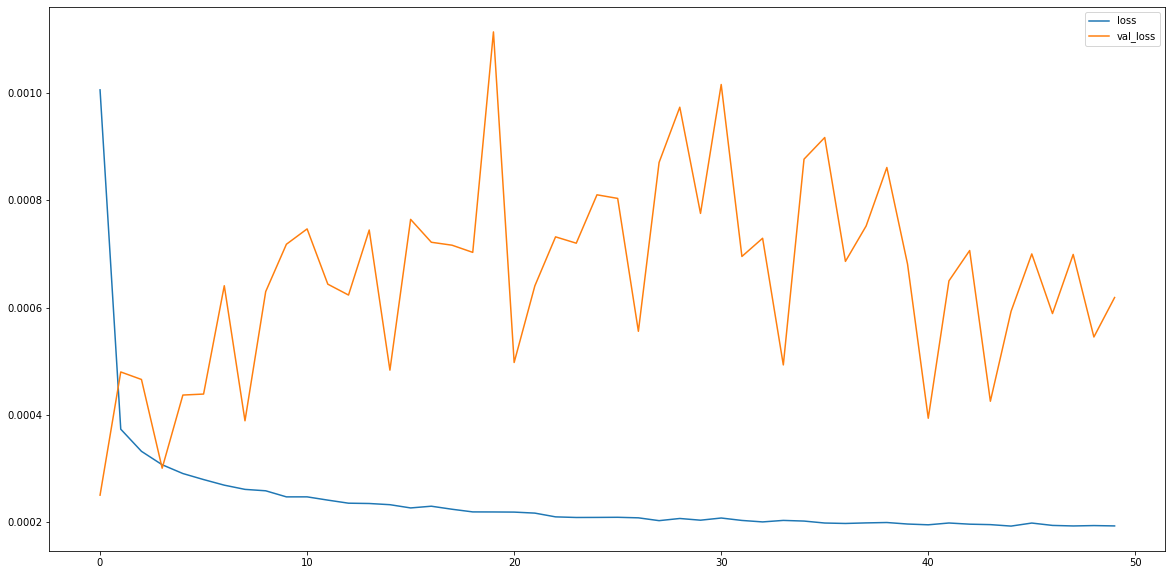

[]

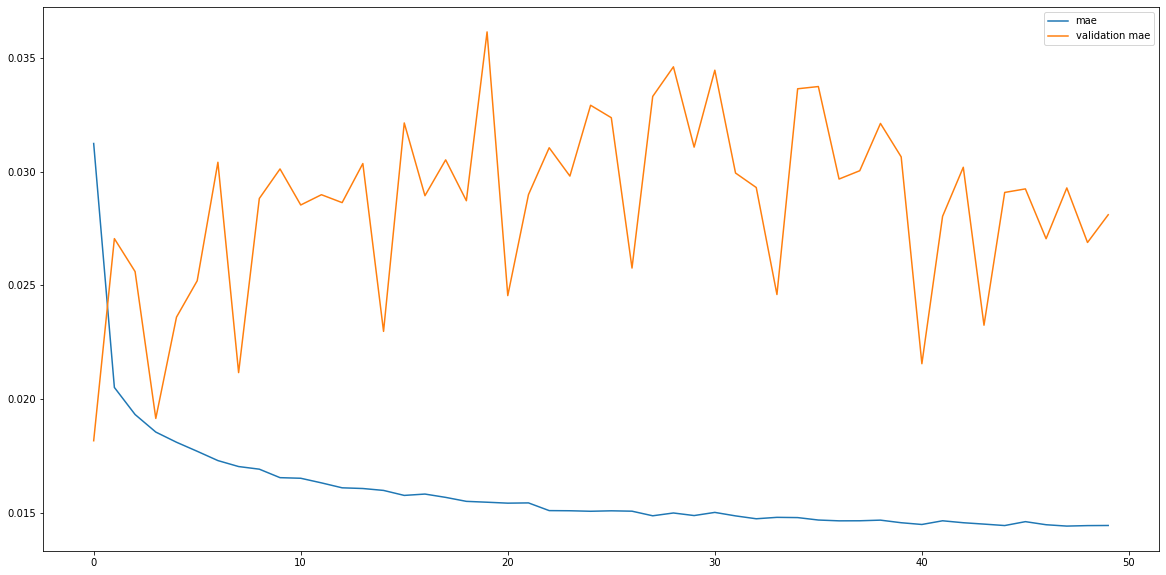

In [48]:
loss_multiple_layers = model_multiple_layers_history.history['loss']
mae_multiple_layers = model_multiple_layers_history.history['mae']
val_loss_multiple_layers = model_multiple_layers_history.history['val_loss']
val_mae_multiple_layers = model_multiple_layers_history.history['val_mae']


plt.plot(loss_multiple_layers, label='loss')
plt.plot(val_loss_multiple_layers, label='val_loss')
plt.legend()
plt.show()

plt.plot(mae_multiple_layers, label='mae')
plt.plot(val_mae_multiple_layers, label='validation mae')
plt.legend()
plt.plot()

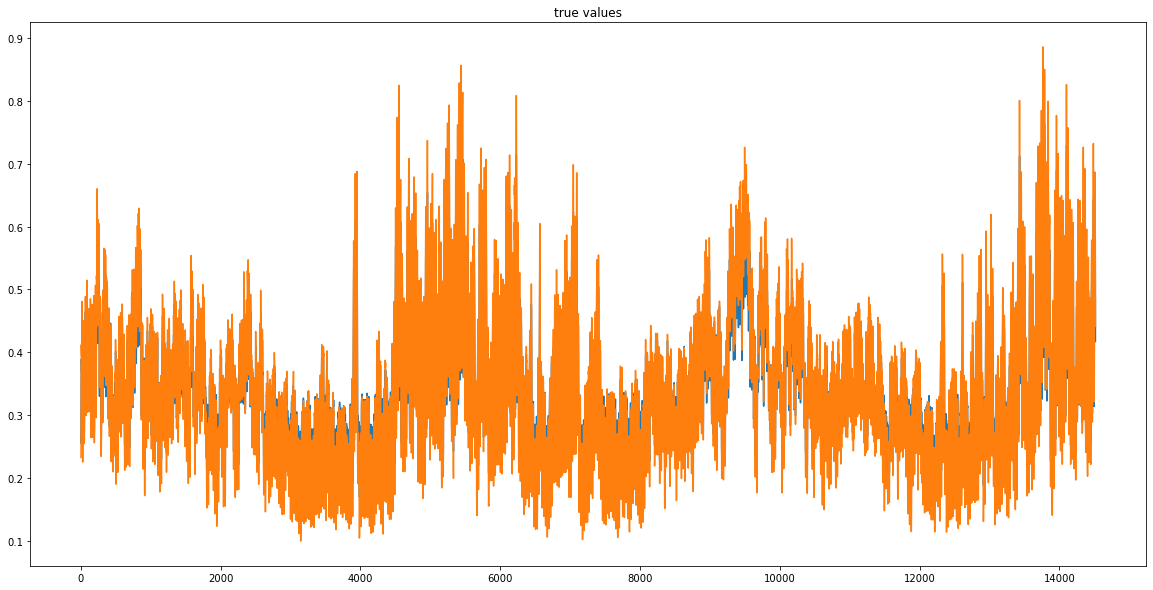

In [49]:
predictions = model_multiple_layers.predict(X_test)
plt.plot(predictions)
plt.title('predictions')
plt.plot(y_test)
plt.title('true values')
plt.show()

In [50]:
mse_multiple_layers = mean_squared_error(y_test, predictions)
print('Mean squared error = ', mse_multiple_layers)

Mean squared error =  0.001025342323868896


#### LSTM

In [52]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 120,193
Trainable params: 120,193
Non-trainable params: 0
_________________________________________________________________


In [54]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)


model_lstm.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
model_lstm_history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
3634/3634 [==============================] - 102s 28ms/step - loss: 2.1631e-04 - mae: 0.0153 - val_loss: 5.3759e-05 - val_mae: 0.0080
Epoch 2/50
3634/3634 [==============================] - 120s 33ms/step - loss: 1.9284e-04 - mae: 0.0143 - val_loss: 5.2043e-05 - val_mae: 0.0077
Epoch 3/50
3634/3634 [==============================] - 137s 38ms/step - loss: 1.8488e-04 - mae: 0.0140 - val_loss: 4.5946e-05 - val_mae: 0.0072
Epoch 4/50
3634/3634 [==============================] - 134s 37ms/step - loss: 1.7381e-04 - mae: 0.0135 - val_loss: 6.7566e-05 - val_mae: 0.0086
Epoch 5/50
3634/3634 [==============================] - 137s 38ms/step - loss: 1.6735e-04 - mae: 0.0132 - val_loss: 4.0430e-05 - val_mae: 0.0067
Epoch 6/50
3634/3634 [==============================] - 127s 35ms/step - loss: 1.6430e-04 - mae: 0.0130 - val_loss: 4.7112e-05 - val_mae: 0.0075
Epoch 7/50
3634/3634 [==============================] - 145s 40ms/step - loss: 1.6164e-04 - mae: 0.0129 - val_loss: 5.5464e-05 - v

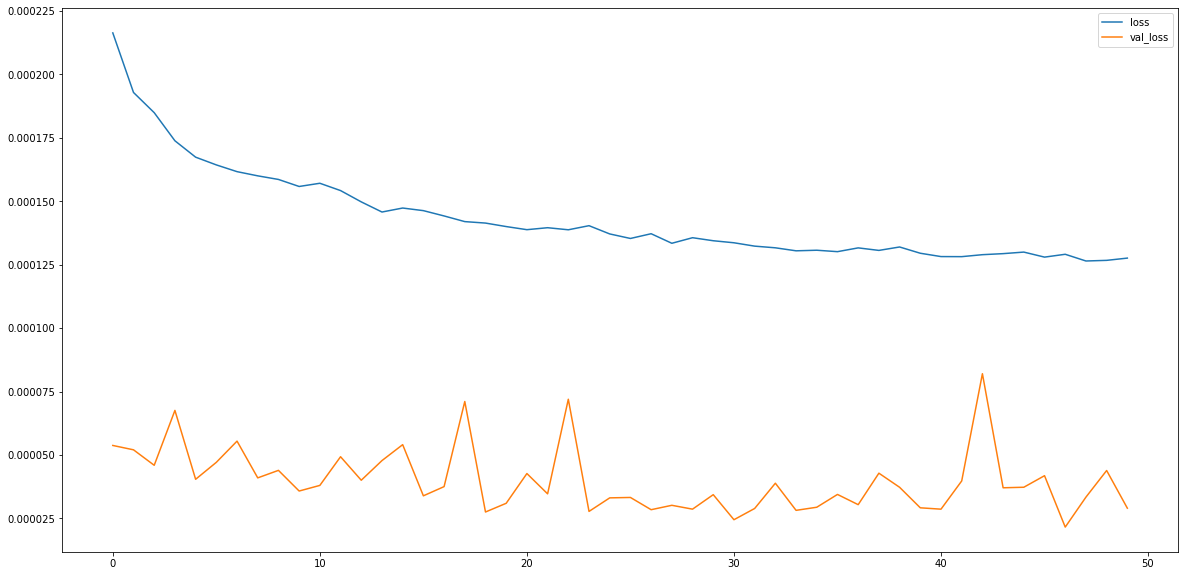

[]

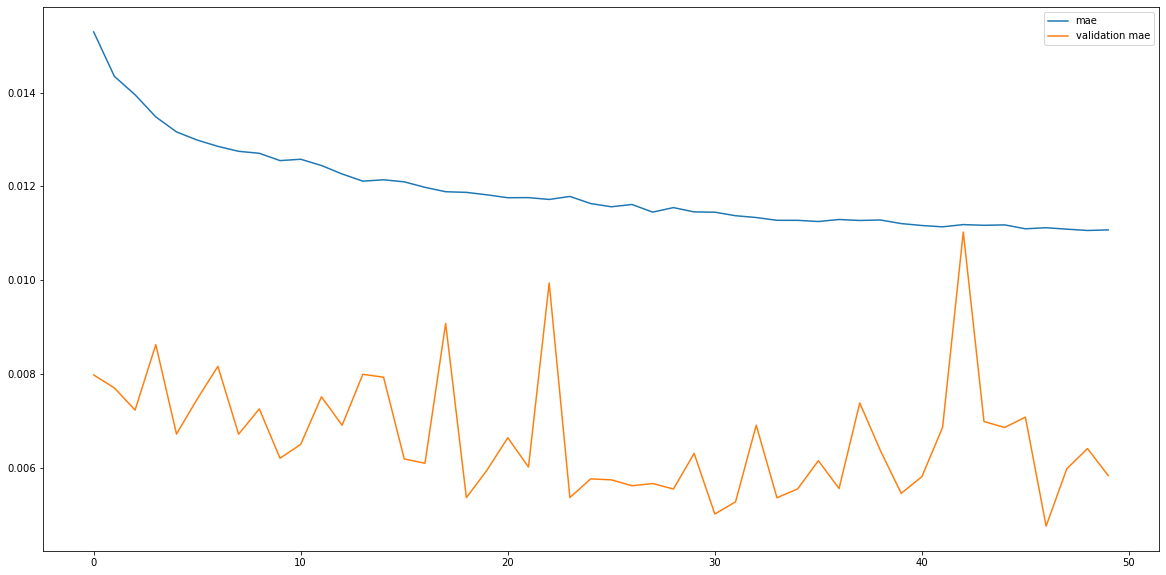

In [55]:
loss_lstm = model_lstm_history.history['loss']
mae_lstm = model_lstm_history.history['mae']
val_loss_lstm = model_lstm_history.history['val_loss']
val_mae_lstm = model_lstm_history.history['val_mae']


plt.plot(loss_lstm, label='loss')
plt.plot(val_loss_lstm, label='val_loss')
plt.legend()
plt.show()

plt.plot(mae_lstm, label='mae')
plt.plot(val_mae_lstm, label='validation mae')
plt.legend()
plt.plot()

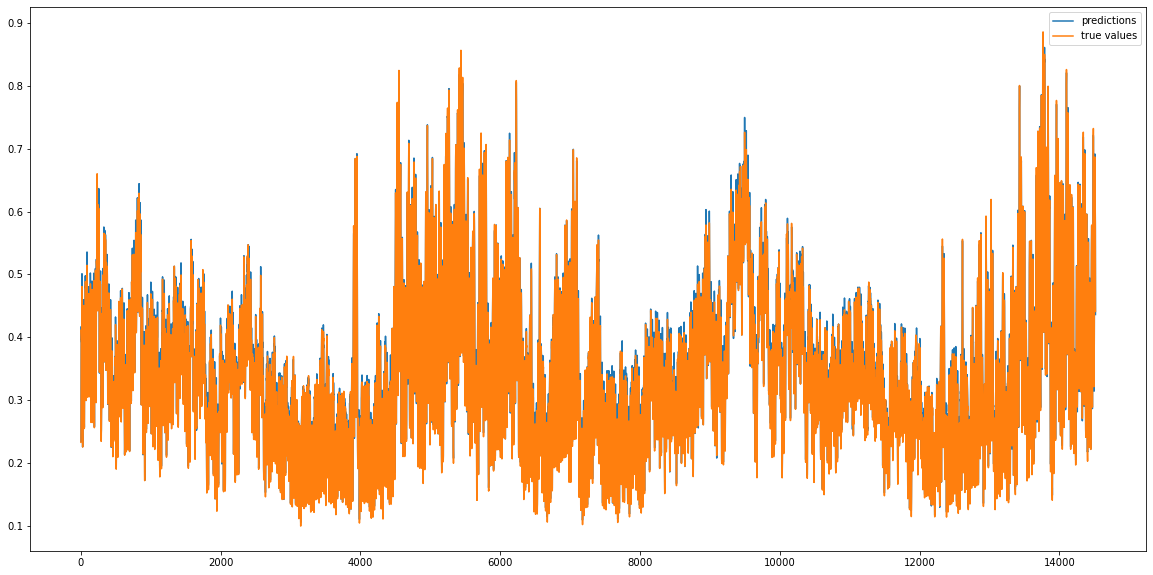

In [64]:
predictions = model_lstm.predict(X_test)
plt.plot(predictions, label='predictions')
plt.plot(y_test, label='true values')
plt.legend()
plt.show()

In [58]:
mse_lstm = mean_squared_error(y_test, predictions)
print('Mean squared error = ', mse_lstm)

Mean squared error =  6.209949537577617e-05


#### LSMT with CONV

In [59]:
model_lstm_conv = Sequential([
    Conv1D(20, (3), activation='relu', input_shape=[None,1]),
    Conv1D(10, (3), activation='relu'),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_lstm_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          80        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 10)          610       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          19200     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [60]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

model_lstm_conv.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
model_lstm_conv_history = model_lstm_conv.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), 
                                              callbacks=[early_stop])

Epoch 1/50
3634/3634 [==============================] - 80s 22ms/step - loss: 0.0012 - mae: 0.0292 - val_loss: 1.2975e-04 - val_mae: 0.0124
Epoch 2/50
3634/3634 [==============================] - 70s 19ms/step - loss: 1.6231e-04 - mae: 0.0135 - val_loss: 3.6366e-04 - val_mae: 0.0203
Epoch 3/50
3634/3634 [==============================] - 79s 22ms/step - loss: 1.1803e-04 - mae: 0.0115 - val_loss: 3.8962e-04 - val_mae: 0.0225
Epoch 4/50
3634/3634 [==============================] - 66s 18ms/step - loss: 1.0440e-04 - mae: 0.0109 - val_loss: 3.8306e-04 - val_mae: 0.0209
Epoch 5/50
3634/3634 [==============================] - 104s 29ms/step - loss: 9.6162e-05 - mae: 0.0104 - val_loss: 4.0076e-04 - val_mae: 0.0240
Epoch 6/50
3634/3634 [==============================] - 95s 26ms/step - loss: 9.0463e-05 - mae: 0.0100 - val_loss: 4.2288e-04 - val_mae: 0.0218
Epoch 7/50
3634/3634 [==============================] - 91s 25ms/step - loss: 8.4547e-05 - mae: 0.0097 - val_loss: 4.7230e-04 - val_mae: 0.

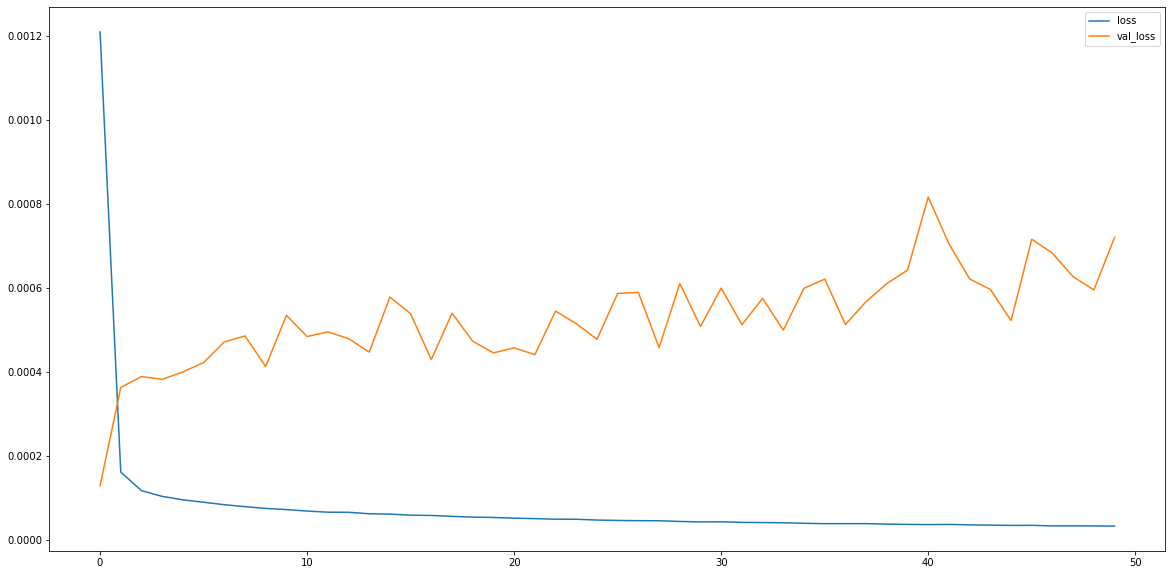

[]

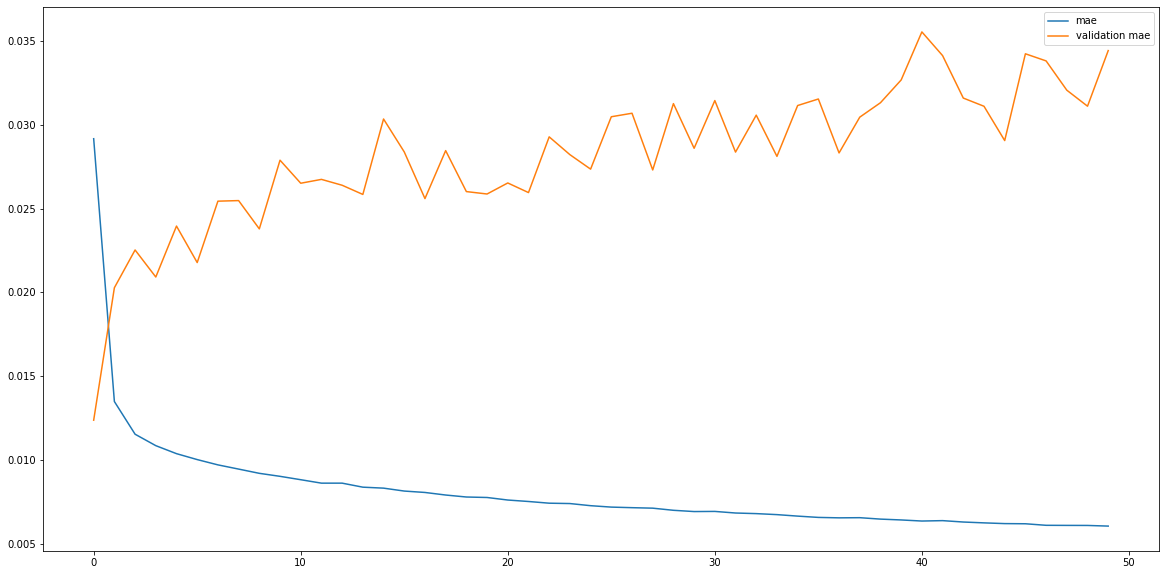

In [62]:
loss_lstm_conv = model_lstm_conv_history.history['loss']
mae_lstm_conv = model_lstm_conv_history.history['mae']
val_loss_lstm_conv = model_lstm_conv_history.history['val_loss']
val_mae_lstm_conv = model_lstm_conv_history.history['val_mae']


plt.plot(loss_lstm_conv, label='loss')
plt.plot(val_loss_lstm_conv, label='val_loss')
plt.legend()
plt.show()

plt.plot(mae_lstm_conv, label='mae')
plt.plot(val_mae_lstm_conv, label='validation mae')
plt.legend()
plt.plot()

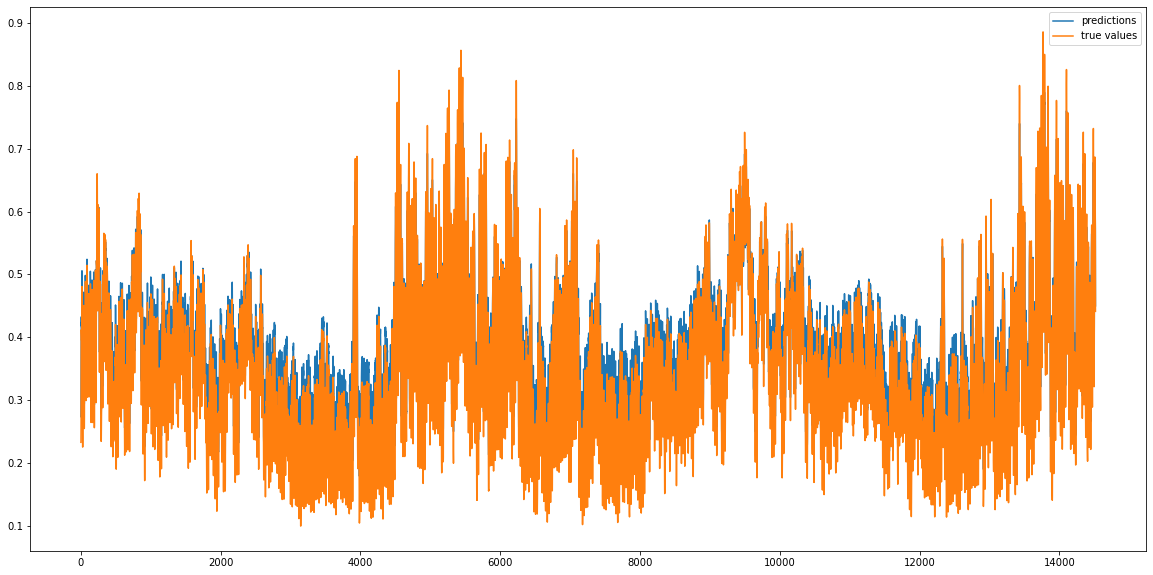

In [65]:
predictions = model_lstm_conv.predict(X_test)
plt.plot(predictions, label='predictions')
plt.plot(y_test, label='true values')
plt.legend()
plt.show()

In [66]:
mse_lstm_conv = mean_squared_error(y_test, predictions)
print('Mean squared error = ', mse_lstm_conv)

Mean squared error =  0.0012961159068884496
